# Computer Vision : Assignment 5

### Mayank Musaddi (20171115)
#### Instructions

Download the test images folder from the following link:
vision.middlebury.edu/flow/data/comp/zip/eval-gray-twoframes.zip if not present already

Make sure to have a folder named `eval-data-gray` in the same folder as this file lies in.
Run the code in jupyter notebook with the file being present outside the test folder

In [1]:
# All the imports

import os 
import sys
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from scipy import signal

In [2]:
# Helper function

def show_images(images,cols=1,titles=None,bboxes=None):
    n = len(images)
    fig = plt.figure()
    
    for i,image in enumerate(images):
        ax = fig.add_subplot(cols, np.ceil(n/float(cols)),i+1)
        ca = plt.gca()
        
        if bboxes is not None:
            bbox = bboxes[i]
            ca.add_patch(Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=2.5, edgecolor='red', facecolor='none'))
        
        if titles is not None:
            ax.set_title(titles[i])
            
        plt.imshow(image, cmap='gray')
        
            
    fig.set_size_inches(np.array(fig.get_size_inches())*n)
    plt.show()
    
def getArrowImage(img, vec):
    u,v = vec
    fig = Figure(figsize=(20,20))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.imshow(img1, cmap='gray')
    kp = cv2.goodFeaturesToTrack(img1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,5*u[y,x],5*v[y,x], width=2, color = (0,0,1))
    ax.axis("off")
    canvas.draw()
    l, b, w, h = fig.bbox.bounds
    arrow_image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape((int(h), int(w), 3))
    return arrow_image

# returns bounding boxes according to the connected components in the segmented image
def getbbox(segmented_image):
    segmentedMask = segmented_image.astype(np.uint8)
    nb_components,output,stats,centroids = cv2.connectedComponentsWithStats(segmentedMask,connectivity = 8)
    sizes = stats[1:,-1]
    avg_size = np.mean(sizes)
    bboxes = []
    for i in range(0,nb_components-1):
        if sizes[i] > avg_size:    
            mask_i = np.zeros((output.shape))
            mask_i[ output == i+1 ] = 1
            mask_i = mask_i.astype(np.uint8)
            
            _, contours, _ = cv2.findContours(mask_i, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            c = max(contours, key=cv2.contourArea)
            x1 = tuple(c[c[:, :, 0].argmin()][0])[0]
            x2 = tuple(c[c[:, :, 0].argmax()][0])[0]
            y1 = tuple(c[c[:, :, 1].argmin()][0])[1]
            y2 = tuple(c[c[:, :, 1].argmax()][0])[1]
            bboxes.append((x1,y1,x2,y2))
    return bboxes

# displays bounding boxes over an image
def markBoundingBox(positions,img):
    im = img.copy()
    for position in positions:
        x1,y1,x2,y2 = position
        cv2.rectangle(im,(x1,y1),(x2,y2),(255,0,0),2)
    show_images([im])

## Optical Flow Function

http://www.inf.fu-berlin.de/inst/ag-ki/rojas_home/documents/tutorials/Lucas-Kanade2.pdf

Implemented according to the above link, the following is a function that takes in 2 images and returns the velocity vectors corresponding to the Lucas Kanade Optical Flow Algorithm.

The function is constructed in 2 parts:

For faster computation we could use cv2's goodFeaturestoTrack function and implement our logic only on those points.

However we could also iterate over every pixel of the image and implement the logic to find the velocity vectors for that point. These vectors are only taken for those points which pass a certain threshold

In [3]:
def opticalFlow(img1, img2, window_size=3,  threshold=1e-2):
    I1,I2 = np.array(img1),np.array(img2)
    height,width = np.shape(I1)

    # Elimination of Noise by applying Gaussian filter of size 3x3
    gaussian_kernel = (3,3)
    I1_smooth = cv2.GaussianBlur(I1, gaussian_kernel, 0)
    I2_smooth = cv2.GaussianBlur(I2, gaussian_kernel, 0)

    # Defining kernels in x,y,t direction for convolution to estimate gradients
    kernel_x = np.array([[-1., 1.], [-1., 1.]]) * 0.25
    kernel_y = np.array([[-1., -1.], [1., 1.]]) * 0.25
    kernel_t = np.array([[1., 1.], [1., 1.]]) * 0.25
    
    # Calculation gradients
    mode='same'
    Ix = signal.convolve2d(I1_smooth,kernel_x, mode=mode) + signal.convolve2d(I2_smooth,kernel_x,mode=mode)
    Iy = signal.convolve2d(I1_smooth,kernel_y, mode=mode) + signal.convolve2d(I2_smooth,kernel_y,mode=mode)
    It = signal.convolve2d(I1_smooth,kernel_t, mode=mode) + signal.convolve2d(I2_smooth,-kernel_t,mode=mode)
    
    u  = np.zeros((height,width))
    v  = np.zeros((height,width))
    w = int(window_size/2)

#     # Calculating the u and v arrays ie the velocity vectors for good features for faster computation
#     features = cv2.goodFeaturesToTrack(img1, 100, 0.01, 10, 3)
#     for feature in features:
#         j,i = feature.ravel()
#         j,i = int(j),int(i)
#         # calculating the derivatives for the neighbouring pixels
#         IX = Ix[i-w:i+w+1, j-w:j+w+1].flatten()
#         IY = Iy[i-w:i+w+1, j-w:j+w+1].flatten()
#         IT = It[i-w:i+w+1, j-w:j+w+1].flatten()
        
#         # Using the minimum least squares solution approach
#         S_T = np.array((IX, IY))
#         S = np.transpose(S_T)
        
#         K = np.matmul(S_T,S)
#         if np.min(abs(np.linalg.eigvals(K))) >= threshold:
#             u[i,j],v[i,j] = np.matmul(np.linalg.pinv(S), IT)
        
    # Calculating the u and v arrays ie the velocity vectors
    for i in range(w,height-w):
        for j in range(w,width-w):
            # calculating the derivatives for the neighbouring pixels
            IX = Ix[i-w:i+w+1, j-w:j+w+1].flatten()
            IY = Iy[i-w:i+w+1, j-w:j+w+1].flatten()
            IT = It[i-w:i+w+1, j-w:j+w+1].flatten()
            
            # Using the minimum least squares solution approach
            S_T = np.array((IX, IY))
            S = np.transpose(S_T)
            
            K = np.matmul(S_T,S)
            if np.min(abs(np.linalg.eigvals(K))) >= threshold:
                u[i,j],v[i,j] = np.matmul(np.linalg.pinv(S), IT)
    return u,v

## Testing of the code
The result of the optical flow is tested for different images obtained vision middlebury website

### Image 1

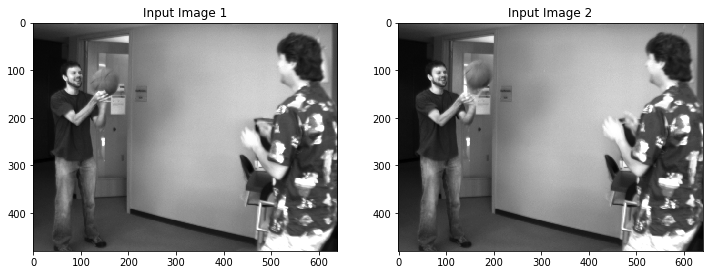

In [6]:
img1 = cv2.imread('./eval-data-gray/Basketball/frame10.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./eval-data-gray/Basketball/frame11.png', cv2.IMREAD_GRAYSCALE)
show_images([img1, img2], titles = ['Input Image 1', 'Input Image 2'])
u,v = opticalFlow(img1, img2, 15)

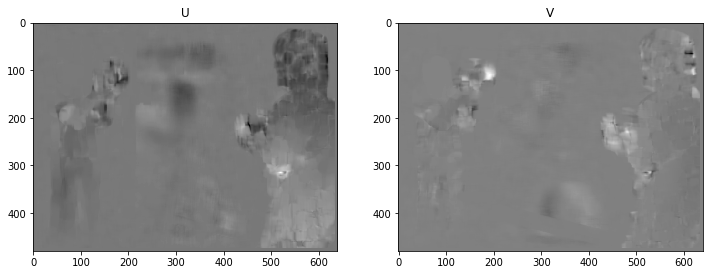

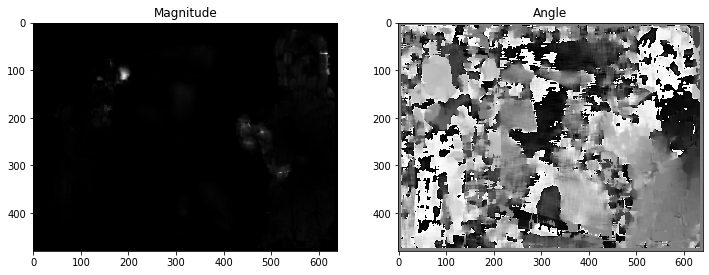

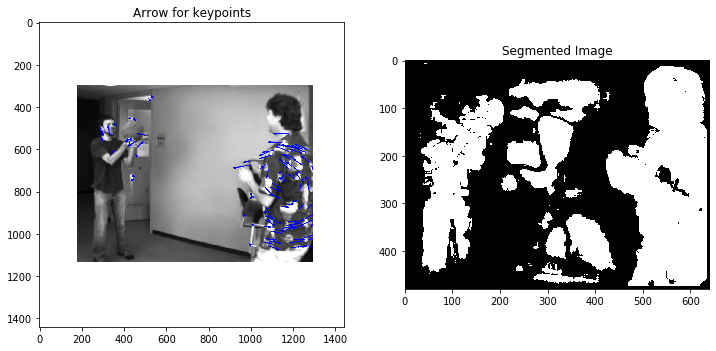

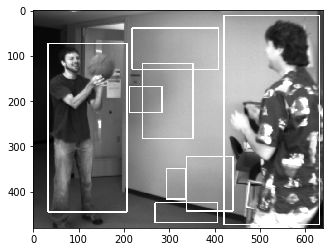

In [7]:
show_images([u, v], titles = ['U', 'V'])
show_images([u**2 + v**2, np.arctan2(v,u)], titles = ['Magnitude', 'Angle'])
arrow_image = getArrowImage(img1, (u,v))
segmented_image = ((u*u+v*v)>1)
show_images([arrow_image, segmented_image], titles = ['Arrow for keypoints', 'Segmented Image'])
bboxes = getbbox(segmented_image)
markBoundingBox(bboxes,img1)

From the results above, we could see that the algorithm has very accurately tracked the position of the movements as evident from the segmented image mask and the bounding boxes.

### Image 2

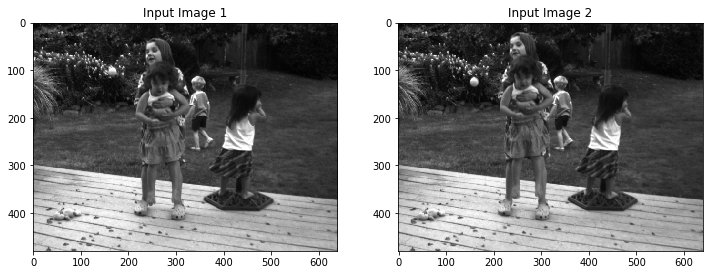

In [8]:
img1 = cv2.imread('./eval-data-gray/Backyard/frame10.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./eval-data-gray/Backyard/frame11.png', cv2.IMREAD_GRAYSCALE)
show_images([img1, img2], titles = ['Input Image 1', 'Input Image 2'])
u1,v1 = opticalFlow(img1, img2, 15)

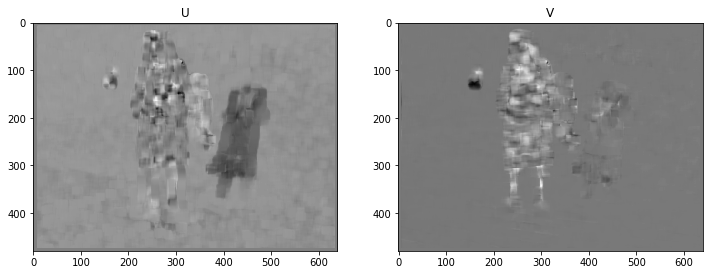

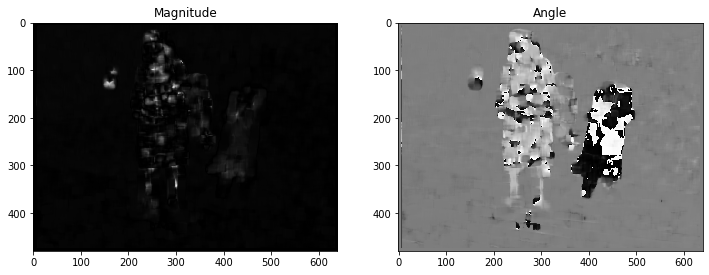

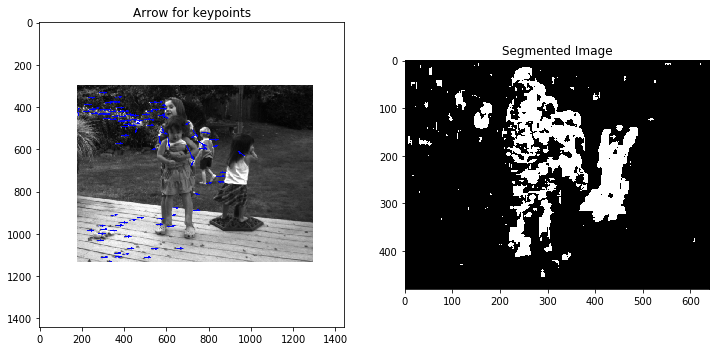

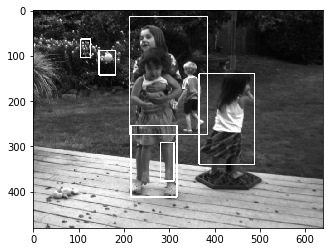

In [12]:
show_images([u1, v1], titles = ['U', 'V'])
show_images([u1**2 + v1**2, np.arctan2(v1,u1)], titles = ['Magnitude', 'Angle'])
arrow_image = getArrowImage(img1, (u1,v1))
segmented_image = ((u1*u1+v1*v1)>6)
show_images([arrow_image, segmented_image], titles = ['Arrow for keypoints', 'Segmented Image'])
bboxes = getbbox(segmented_image)
markBoundingBox(bboxes,img1)

In the above result, we find that the algorithm is so accurate in capturing even the minor movement of the leaves in the background as well as accurate capturing the movement of the subject

### Image 3

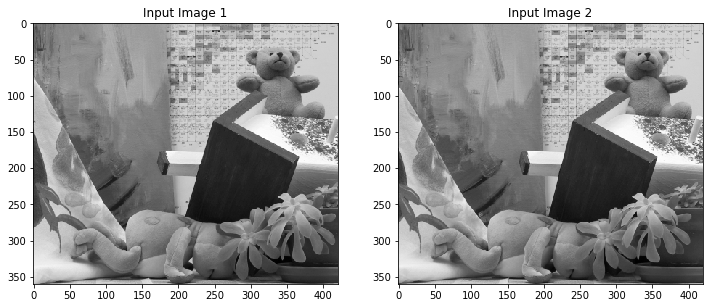

In [43]:
img1 = cv2.imread('./eval-data-gray/Teddy/frame10.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./eval-data-gray/Teddy/frame11.png', cv2.IMREAD_GRAYSCALE)
show_images([img1, img2], titles = ['Input Image 1', 'Input Image 2'])
u2,v2 = opticalFlow(img1, img2, 15)

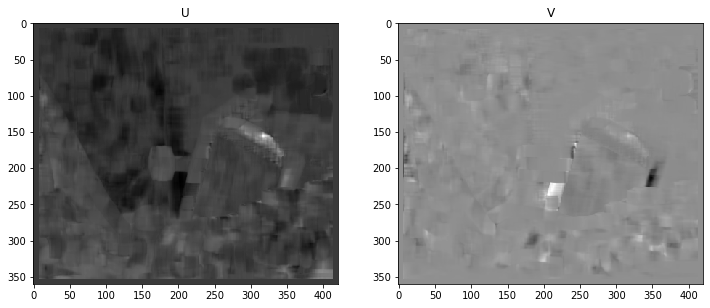

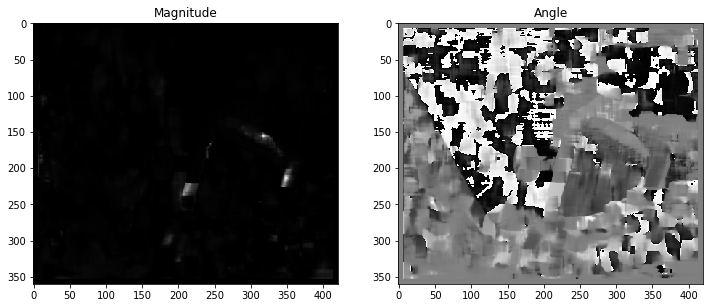

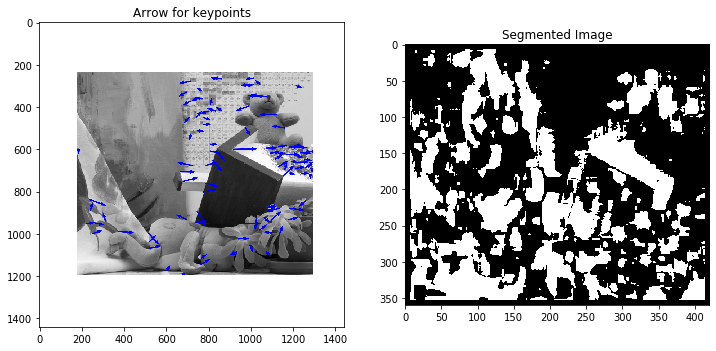

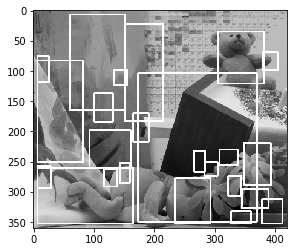

In [45]:
show_images([u2, v2], titles = ['U', 'V'])
show_images([u2**2 + v2**2, np.arctan2(v2,u2)], titles = ['Magnitude', 'Angle'])
arrow_image = getArrowImage(img1, (u2,v2))
segmented_image = ((u2*u2+v2*v2)>10)
show_images([arrow_image, segmented_image], titles = ['Arrow for keypoints', 'Segmented Image'])
bboxes = getbbox(segmented_image)
markBoundingBox(bboxes,img1)

## Object Tracking

We use the above optical flow algorithm implemented for two consecutive image over a video for tracking the movement of objects.

For doing so we have first converted the input video into frame wise images. For every consecutive frames we evaluate the optical flow. Using the velocity vectors obtained from the optical flow results, we construct a segmented images by thresholding the magnitude of the vectors. We find the connected compoenents from the thresholded image and put a bounding box for every big enough sized component. This bounding box images are assembled in the `output` folder from which the video is reconstructed using imageToVideo function

In [13]:
def videoToImage(path,image_folder):
    vo = cv2.VideoCapture(path)
    i = 0
    valid, image = vo.read()
    while valid:
        cv2.imwrite("./"+image_folder+"/"+str(i)+".png", image) 
        i += 1
        valid, image = vo.read()
    if i==0:
        print("File does not exist")
    vo.release()

In [14]:
def imageToVideo(image_folder,video_name,fps=15):
    images = sorted([img for img in os.listdir(image_folder)], key=lambda s: int(s[:-4]))
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    
    fourcc = cv2.VideoWriter_fourcc(*"mp4v") 
    video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))
    
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [15]:
# returns velocity vectors for every consecutive image in the input_folder
def objectTracking(input_folder):
    vec = []
    
    files = sorted([img for img in os.listdir(input_folder)], key=lambda s: int(s[:-4]))
    images = []
    for file in files:
        images.append(cv2.imread(os.path.join(input_folder, file),cv2.IMREAD_GRAYSCALE))

    for i in range(len(images)-1):
        img1 = images[i]
        img2 = images[i+1]
        u, v = opticalFlow(img1, img2)
        vec.append((u,v))
        print(str(i+1)+" out of "+str(len(files))+" images completed")                  
    return vec

In [36]:
# using the velocity vectors it finds the segmented image,
# divides it into connected components and outputs image with the bounding box for each connected component
def putBoundingBox(input_folder,output_folder, vecs, threshold=1):
    files = sorted([img for img in os.listdir(input_folder)], key=lambda s: int(s[:-4]))
    images = []
    for file in files:
        images.append(cv2.imread(os.path.join(input_folder, file),cv2.IMREAD_GRAYSCALE))
    
    for i in range(len(images)-1):
        u,v = vecs[i]
        segmented_image = ((u*u+v*v)>threshold)
        bboxes = getbbox(segmented_image)
        im = images[i].copy()
        for bbox in bboxes:
            x1,y1,x2,y2 = bbox
            if y2-y1 > 50:
                cv2.rectangle(im,(x1,y1),(x2,y2),(255,0,0),2)
        cv2.imwrite(os.path.join(output_folder, str(i) + '.png'), im)    

In [17]:
# All the file locations
video_name = "./eval-data-gray/final2.mp4"
image_folder = './eval-data-gray/extract'
output_folder = './eval-data-gray/output'
output_name = 'out2.mp4'

In [18]:
videoToImage(video_name,image_folder)

First we take in 2 frames of the video and evaluate which window size and thresholding is giving us our desired result of image segmentation and tracking. According we use those variables for the whole video

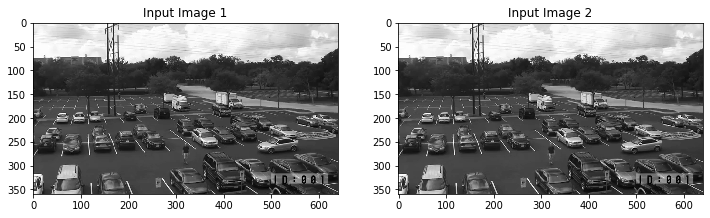

In [19]:
img1 = cv2.imread('./eval-data-gray/extract/0.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./eval-data-gray/extract/1.png', cv2.IMREAD_GRAYSCALE)
show_images([img1, img2], titles = ['Input Image 1', 'Input Image 2'])
u3,v3 = opticalFlow(img1, img2, 15)

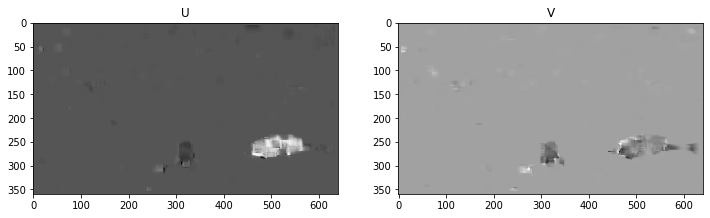

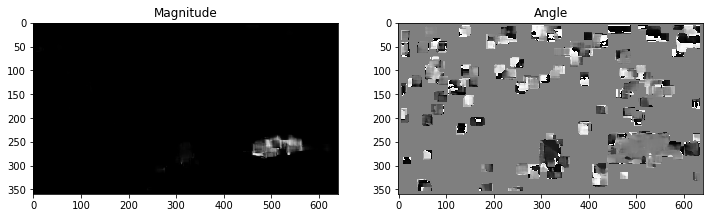

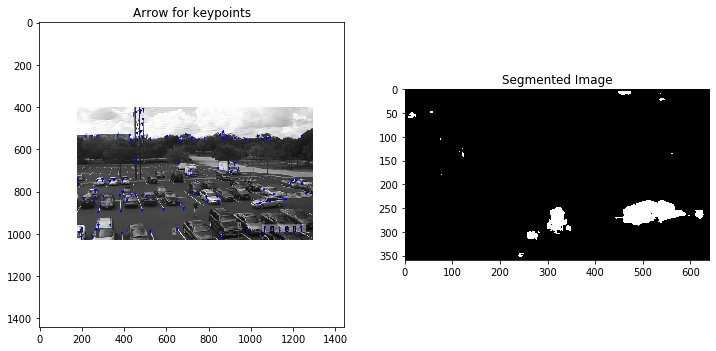

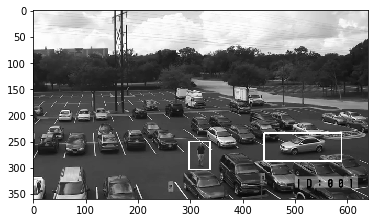

In [20]:
show_images([u3, v3], titles = ['U', 'V'])
show_images([u3**2 + v3**2, np.arctan2(v3,u3)], titles = ['Magnitude', 'Angle'])
arrow_image = getArrowImage(img1, (u3,v3))
segmented_image = ((u3*u3+v3*v3)>0.1)
show_images([arrow_image, segmented_image], titles = ['Arrow for keypoints', 'Segmented Image'])
bboxes = getbbox(segmented_image)
markBoundingBox(bboxes,img1)

Evaluating velocity vectors for the whole video and outputs it into the vecs variable from which the segmented image is then made

In [21]:
vecs = objectTracking(image_folder)

1 out of 47 images completed
2 out of 47 images completed
3 out of 47 images completed
4 out of 47 images completed
5 out of 47 images completed
6 out of 47 images completed
7 out of 47 images completed
8 out of 47 images completed
9 out of 47 images completed
10 out of 47 images completed
11 out of 47 images completed
12 out of 47 images completed
13 out of 47 images completed
14 out of 47 images completed
15 out of 47 images completed
16 out of 47 images completed
17 out of 47 images completed
18 out of 47 images completed
19 out of 47 images completed
20 out of 47 images completed
21 out of 47 images completed
22 out of 47 images completed
23 out of 47 images completed
24 out of 47 images completed
25 out of 47 images completed
26 out of 47 images completed
27 out of 47 images completed
28 out of 47 images completed
29 out of 47 images completed
30 out of 47 images completed
31 out of 47 images completed
32 out of 47 images completed
33 out of 47 images completed
34 out of 47 images

In [41]:
putBoundingBox(image_folder,output_folder, vecs, threshold=0.1)

In [42]:
imageToVideo(output_folder,output_name,fps=10)

The resulting video obtained is uploaded at https://drive.google.com/drive/folders/1tYMuj35K-KcRfh6aNBRXhono1nEPx-9i?usp=sharing.


From the video that we obtain we find that the objects are very accurately tracked and segmented, and we could alter some constants to obtain the tracking and segmentation of small or big objects which is very convenient.  We obtained the result for two separate videos and observe that it is capable to track even multiple objects

#### Analyze how does your algorithm work when camera is moving

When a camera moves it is equivalent to the object moving in the opposite direction. All the interest points in the image are taken into consideration by the algorithm and it tracks them as moving and thus segments them. It is evident from `Image 3` example above where there is a shift in the camera rotation and in the `arrow for keypoints` image result all the corner points are segmented and tracked as moved in the opposite direction from the camera